In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import pipeline
import json
from skimage import util
from skimage import io


def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


def get_targets(dataset, seqid):
    '''Returns array of n_objects x n_frames x coords'''
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0, 1)


def draw_circle(ax, r, c, radius, color):
    circle = plt.Circle((c, r), radius, color=color, fill=False)
    ax.add_artist(circle)

    
def draw_target(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='r')
    
    
def draw_prediction(ax, r, c):
    draw_circle(ax, r, c, radius=15, color='g')

    
def get_sequence(seqid):
    frames = [util.img_as_float(io.imread(f"../spotGEO/train/{seqid}/{i+1}.png", as_gray=True)) for i in range(0, 5)]
    frames = np.array(frames)
    return frames


def extract_region(arr, r0, c0, radius):
    """ Returns the values within a radius of the given x, y coordinates """
    return arr[(r0 - radius) : (r0 + radius + 1), (c0 - radius) : (c0 + radius + 1)]


In [2]:
seqid = 59

dataset = read_annotation_file('../spotGEO/train_anno.json')

targets = get_targets(dataset, seqid)

frames = get_sequence(seqid)


pipeline.PATH = '../spotGEO'
pipeline.MODEL_PATH = '../mainfilter-2020_06_18.h5'

output = pipeline.process(seqid)

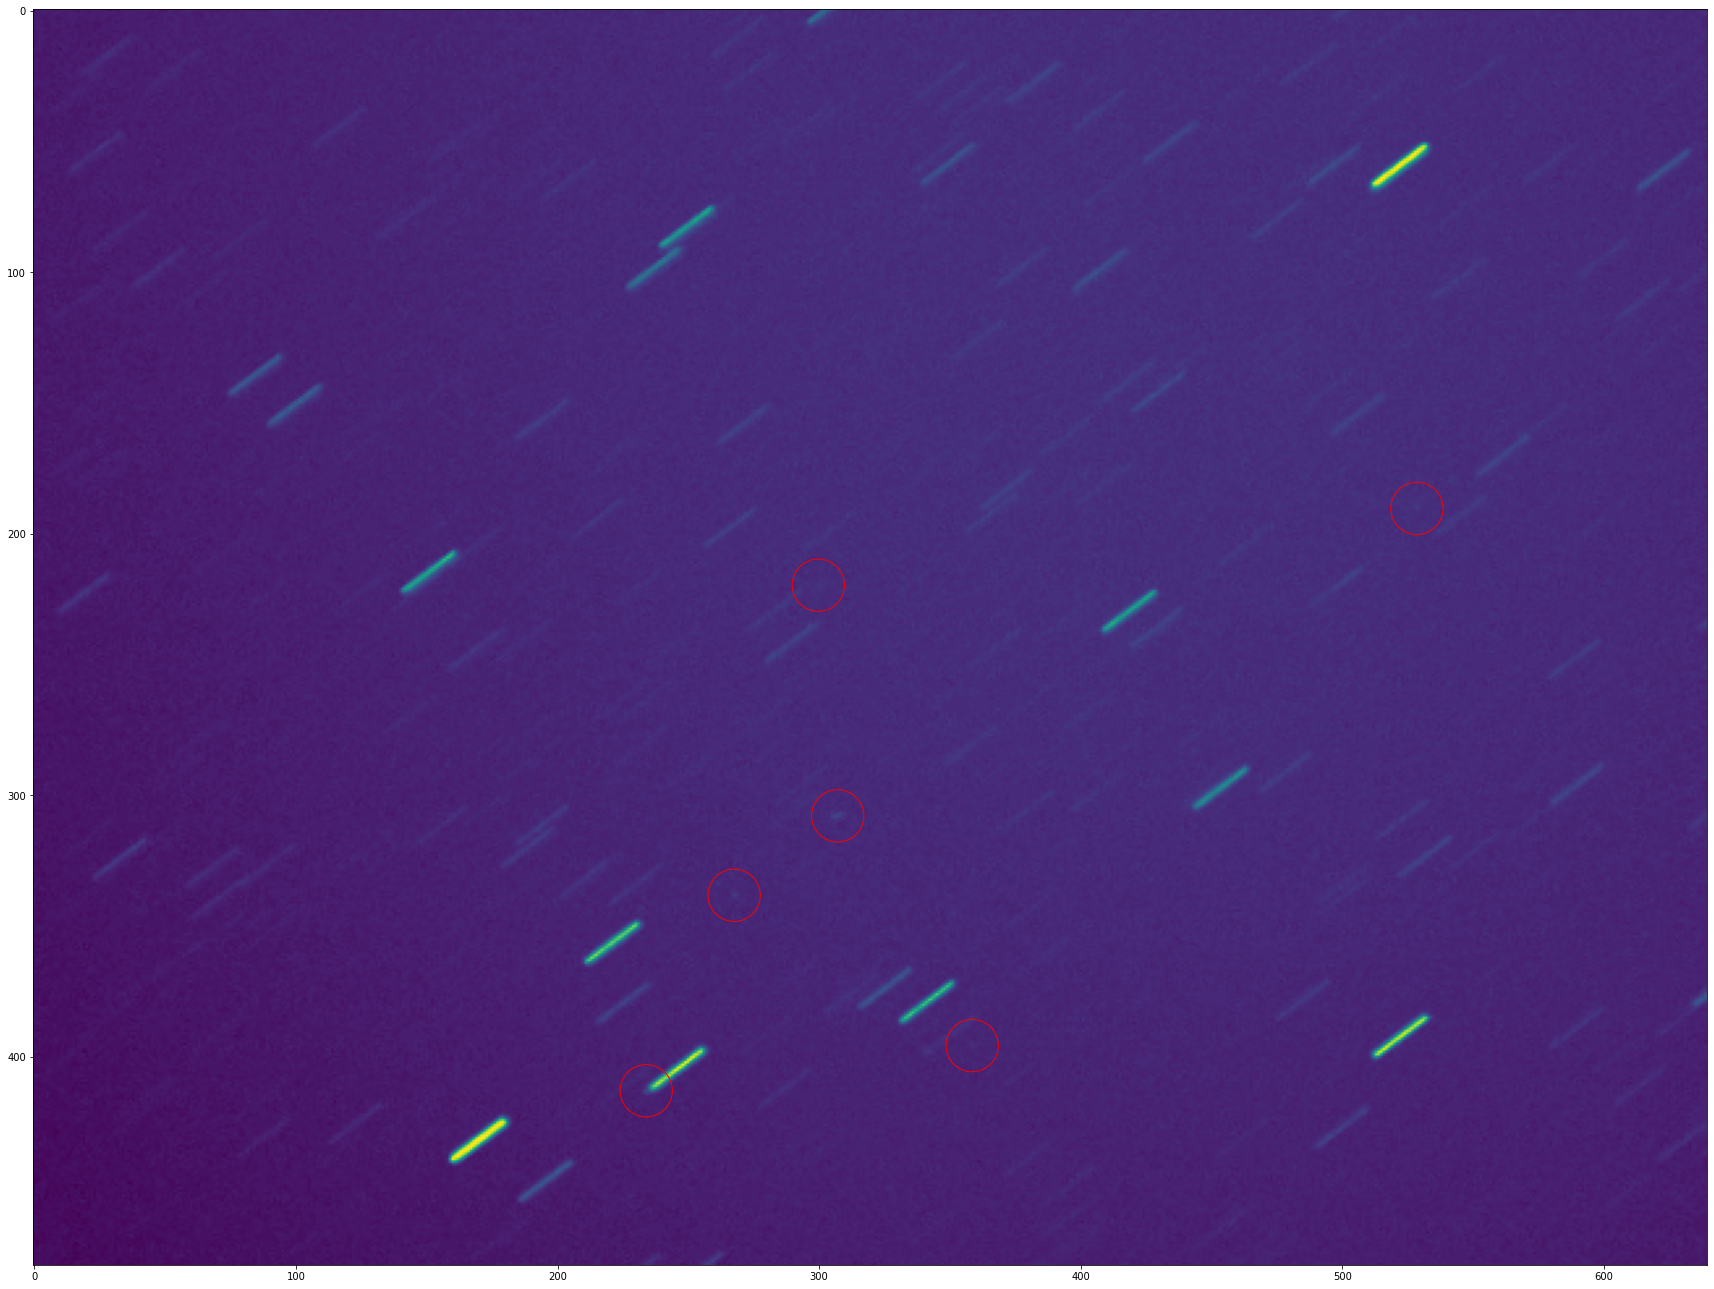

In [3]:
%matplotlib inline

frameid = 0

frame = frames[frameid]

I = frame 

plt.figure(figsize=(30, 30))

plt.imshow(I)
for x, y in targets[:, frameid]:
    draw_target(plt.gcf().gca(), y, x)
plt.show()

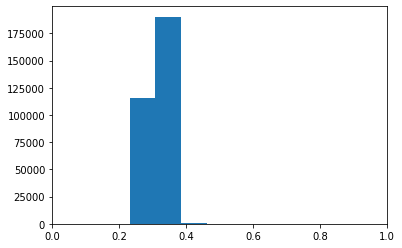

In [4]:
plt.hist(I.ravel())
plt.xlim([0, 1])
plt.show()

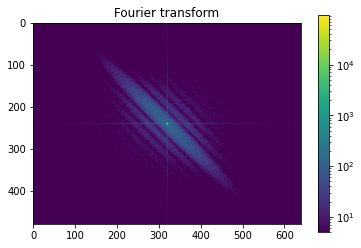

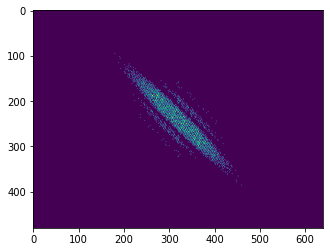

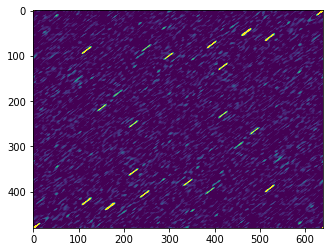

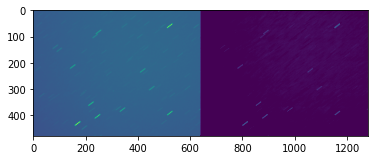

In [5]:
# Show the results
from scipy import fftpack

im_fft = fftpack.fftshift(fftpack.fft2(I))

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm

    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(im_fft)
plt.title('Fourier transform')
plt.show()

notch = im_fft > 20

plt.imshow(notch)
plt.show()

iout = fftpack.fftshift(im_fft * (1 - notch))

Iout = np.real(fftpack.ifft2(iout))

Ifilter = np.real(fftpack.ifft2(fftpack.fftshift(notch*10e2)))

plt.imshow(Ifilter, vmin=0, vmax=1)
plt.show()

plt.imshow(np.hstack([I, Iout]), vmin=0, vmax=1)
plt.show()

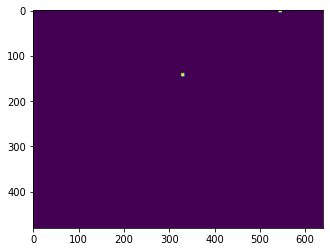

0.00015151051572026564 1.9997361349172627


In [6]:
from skimage import util
from skimage import morphology
from skimage import filters

n = 1e-4

Idelta = np.zeros((480, 640))
Idelta = util.random_noise(Idelta, mode='s&p', salt_vs_pepper=n)
Idelta = filters.gaussian(Idelta, sigma=0.5)

plt.imshow( morphology.dilation(Idelta, selem=morphology.square(7)) )
plt.show()

im_fft = fftpack.fftshift(fftpack.fft2(Idelta))

x = np.abs(im_fft).ravel()

print(x.min(), x.max())

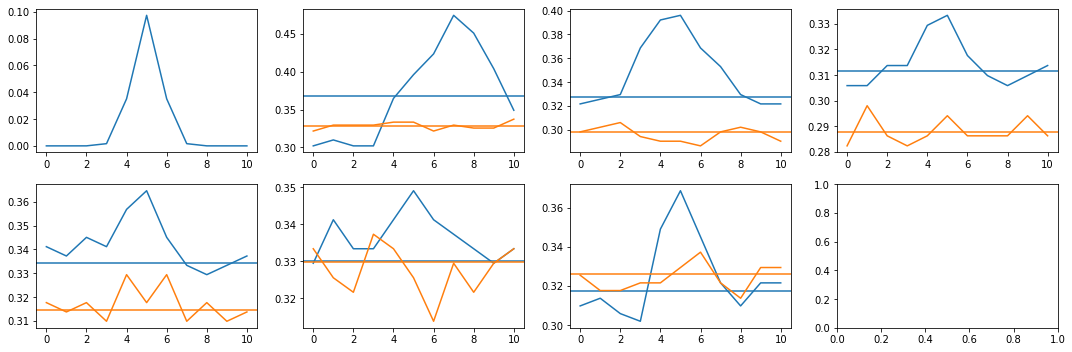

In [7]:
frameid = 0
frame = frames[frameid]

# Realize model for target
Idelta = np.zeros((11, 11))
Idelta[5, 5] = 1
Idelta = 0.3*filters.gaussian(Idelta, sigma=0.7)

# Select regions with target
regions_with = targets[:, frameid]

# Select empty regions
Imask = (frame - filters.gaussian(frame, sigma=20)) < 0.01
S = np.zeros((480, 640))
S[10:480-10, 10:640-10] = 1
Imask = Imask * S

X = np.c_[np.where(Imask)]
regions_without = X[np.random.choice(len(X), size=len(regions_with))]

# Plot
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
axs = axs.ravel()

axs[0].plot(Idelta[5])

for i, (c, r) in enumerate(regions_with):
    Iregion = extract_region(frame, int(r + 0.5), int(c + 0.5), radius=5)
    x = Iregion[5]    
    axs[i + 1].plot(x)
    axs[i + 1].axhline(np.mean(Iregion), c='C0')

for i, (r, c) in enumerate(regions_without):
    Iregion = extract_region(frame, int(r + 0.5), int(c + 0.5), radius=5)
    x = Iregion[5]    
    axs[i + 1].plot(x)
    axs[i + 1].axhline(np.mean(Iregion), c='C1')

plt.tight_layout()
plt.show()

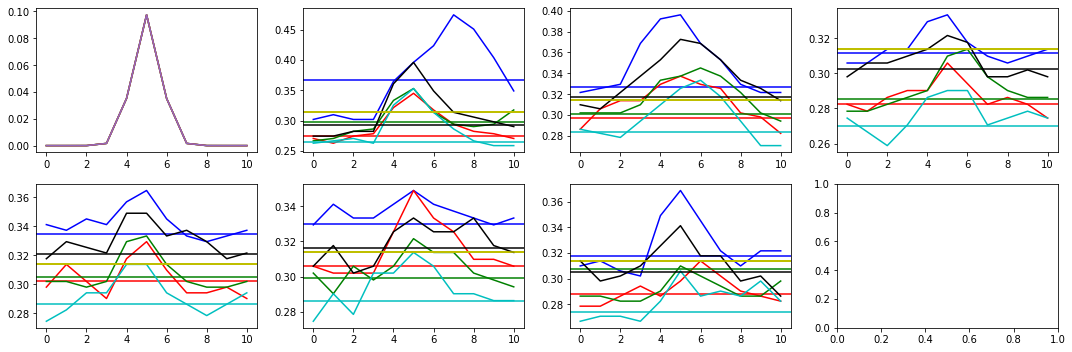

In [8]:
# Show evolution of target intensity

mean_thr = np.mean(frame)

fig, axs = plt.subplots(2, 4, figsize=(15, 5))
axs = axs.ravel()

colors = ['b', 'r', 'g', 'c', 'k']

for frameid in range(0, 5):
    frame = frames[frameid]
    # frame = (frame - filters.gaussian(frame, sigma=20))
    frame = np.clip(frame, 0, 1)

    # Realize model for target
    Idelta = np.zeros((11, 11))
    Idelta[5, 5] = 1
    Idelta = 0.3*filters.gaussian(Idelta, sigma=0.7)

    # Select regions with target
    regions_with = targets[:, frameid]

    # Plot
    axs[0].plot(Idelta[5])

    for i, (c, r) in enumerate(regions_with):
        Iregion = extract_region(frame, int(r + 0.5), int(c + 0.5), radius=5)
        x = Iregion[5]    
        axs[i + 1].plot(x, c=colors[frameid])
        axs[i + 1].axhline(mean_thr, c='y')
        axs[i + 1].axhline(np.mean(Iregion), c=colors[frameid])
        

plt.tight_layout()
plt.show()

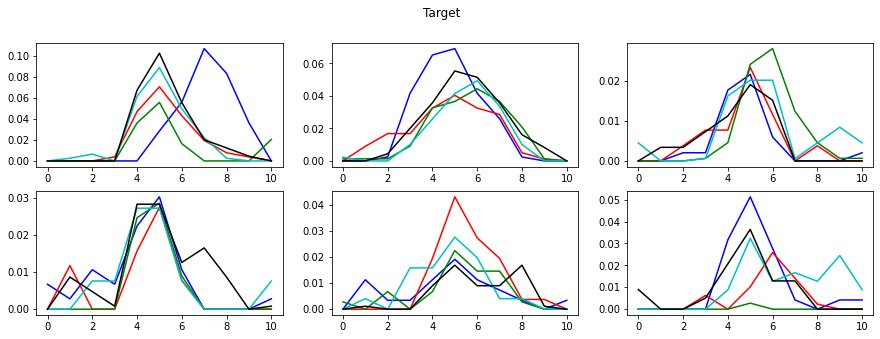

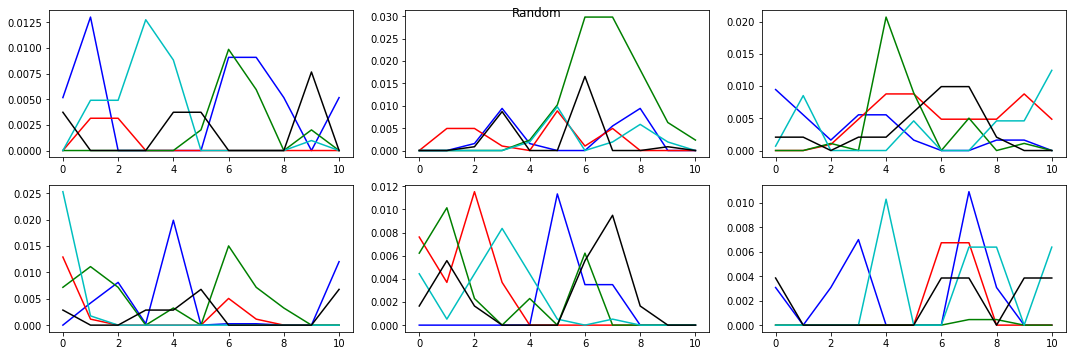

In [9]:
# Show evolution of difference to mean

fig, axs = plt.subplots(2, 3, figsize=(15, 5))
fig1, axs1 = plt.subplots(2, 3, figsize=(15, 5))

fig.suptitle('Target')
fig1.suptitle('Random')

axs = axs.ravel()
axs1 = axs1.ravel()

colors = ['b', 'r', 'g', 'c', 'k']

for frameid in range(0, 5):
    frame = frames[frameid]
    
    # Select regions with target
    regions_with = targets[:, frameid]
    
    # Select empty regions
    Imask = frame
    S = np.zeros((480, 640))
    S[10:480-10, 10:640-10] = 1
    Imask = Imask * S

    X = np.c_[np.where(Imask)]
    regions_without = X[np.random.choice(len(X), size=len(regions_with))]

    # Plot
    for i, (c, r) in enumerate(regions_with):
        Iregion = extract_region(frame, int(r + 0.5), int(c + 0.5), radius=5)
        x = Iregion[5]
        s = np.clip(x - np.mean(Iregion), 0, 1)
        axs[i].plot(np.clip(s, 0, 1), c=colors[frameid])
        
    for i, (r, c) in enumerate(regions_without):
        Iregion = extract_region(frame, int(r + 0.5), int(c + 0.5), radius=5)
        x = Iregion[5]
        s = np.clip(x - np.mean(Iregion), 0, 1)
        axs1[i].plot(np.clip(s, 0, 1), c=colors[frameid])

plt.tight_layout()
plt.show()

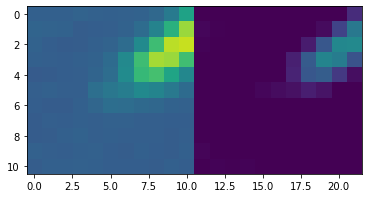

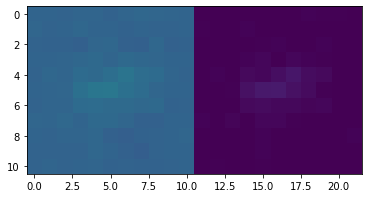

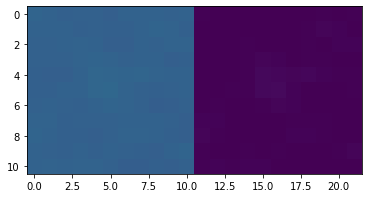

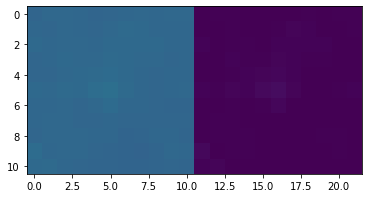

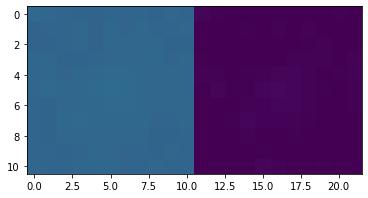

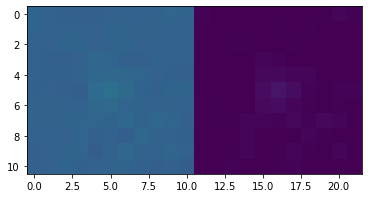

In [10]:
# Peak is larger than local mean

frameid = 0

frame = frames[frameid]
regions_with = targets[:, frameid]

Iout = filters.rank.mean(util.img_as_ubyte(frame), morphology.square(11))
Iout = util.img_as_float(Iout)
Iout = np.clip(frame - Iout, 0, 1)

for i, (c, r) in enumerate(regions_with):
    Iregion = extract_region(frame, int(r + 0.5), int(c + 0.5), radius=5)
    Iregion_out = extract_region(Iout, int(r + 0.5), int(c + 0.5), radius=5)
    
    plt.imshow( np.hstack([Iregion, Iregion_out]), vmin=0, vmax=1 )
    plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: FutureWarning: As of scikit-image 0.16, automated rescaling of sigma to match any internal rescaling of the image is performed. Setting rescale_sigma to False, will disable this new behaviour. To avoid this warning the user should explicitly set rescale_sigma to True or False.
  This is separate from the ipykernel package so we can avoid doing imports until


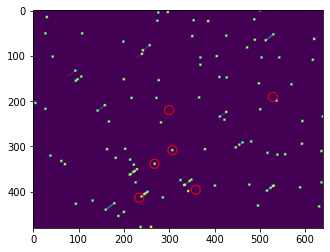

0.46958936714692806


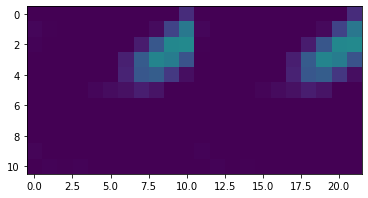

0.06931040248374801


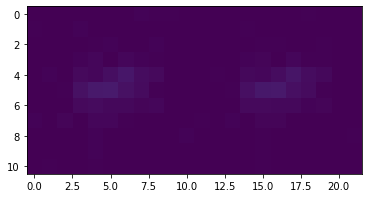

0.022993368221306102


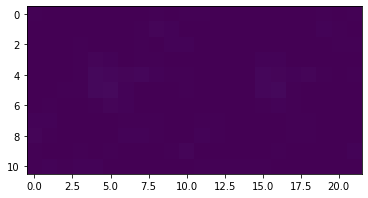

0.03075506919742984


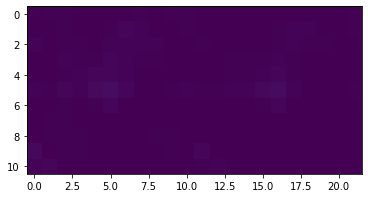

0.017264338175750578


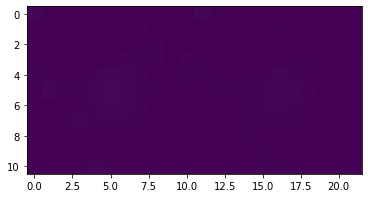

0.05246420178728054


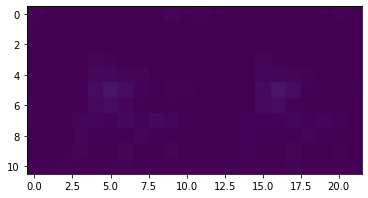

In [23]:
from skimage import restoration

Ires = restoration.denoise_wavelet(Iout)
Imaxima = morphology.h_maxima(Ires, 0.03)

plt.imshow( np.clip(Ires + morphology.dilation(Imaxima, selem=morphology.square(5)), 0, 1) )
for x, y in targets[:, frameid]:
    draw_target(plt.gcf().gca(), y, x)
plt.show()


for i, (c, r) in enumerate(regions_with):
    Iregion = extract_region(Iout, int(r + 0.5), int(c + 0.5), radius=5)
    Iregion_out = extract_region(Ires, int(r + 0.5), int(c + 0.5), radius=5)
    
    print(Iregion_out.max())
    plt.imshow( np.hstack([Iregion, Iregion_out]), vmin=0, vmax=1 )
    plt.show()
    


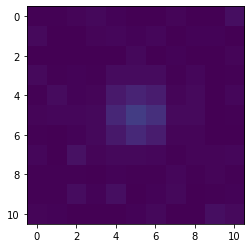

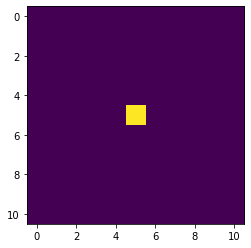

In [47]:
Idelta = np.zeros((11, 11))
Idelta[5, 5] = 1

psf = filters.gaussian(Idelta, sigma=1) + np.random.exponential(1e-2, size=Idelta.shape)

plt.imshow(psf, vmin=0, vmax=1)
plt.show()

Ires = restoration.richardson_lucy(Idelta, psf)

plt.imshow(Ires)
plt.show()

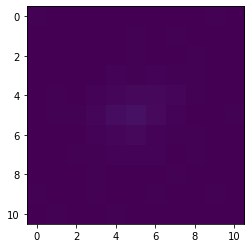

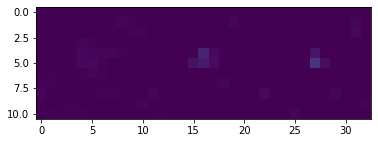

In [63]:
# Compare synthetic psf from learnt psf

psf = filters.gaussian(Idelta, sigma=1) + np.random.exponential(1e-2, size=Idelta.shape)

Iregions = []
for i in [1, 3, 4, 5]:
    c, r = regions_with[i]
    Iregion = extract_region(Iout, int(r + 0.5), int(c + 0.5), radius=5)
    Iregions.append(Iregion)

psf1 = np.mean(Iregions, axis=0)

plt.imshow(psf1, vmin=0, vmax=1)
plt.show()

# Extract second region
c, r = regions_with[2]
Iregion2 = extract_region(Iout, int(r + 0.5), int(c + 0.5), radius=5)

Ires = restoration.richardson_lucy(Iregion2, psf)
Ires1 = restoration.richardson_lucy(Iregion2, psf1)

plt.imshow(np.hstack([Iregion2, Ires, Ires1]), vmin=0, vmax=1)
plt.show()




1.0


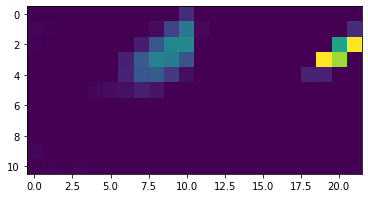

0.6234400126329734


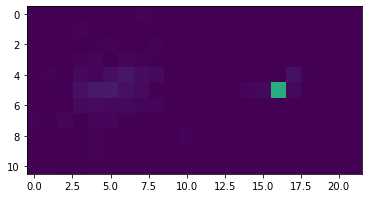

0.11469611115896185


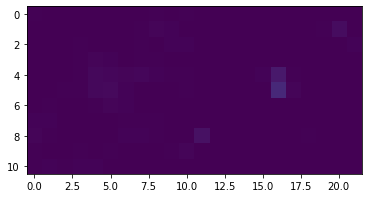

0.15482976274192858


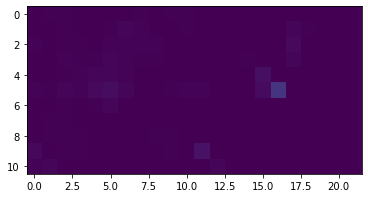

0.2571728546411748


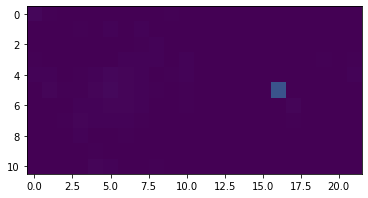

0.4148271645301013


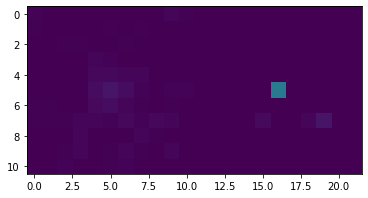

regions without
0.09832169196705583


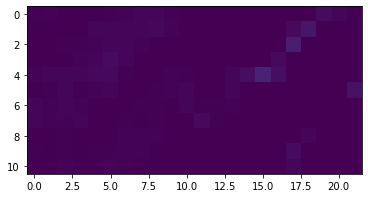

0.08206675291400942


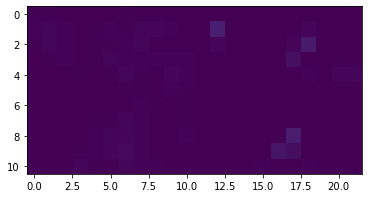

0.10381798254698738


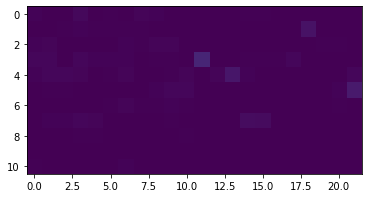

0.07889179805836544


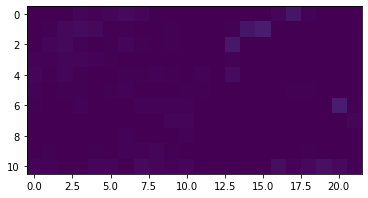

0.10039033933665231


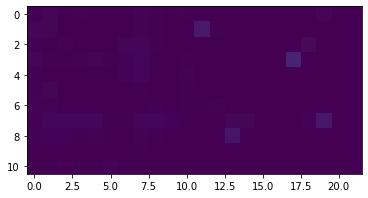

0.08417589035347232


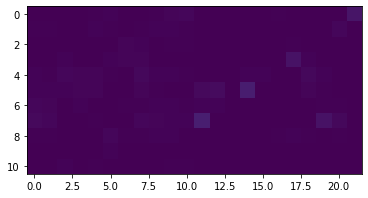

In [64]:
Ires = restoration.richardson_lucy(Iout, psf1)

for i, (c, r) in enumerate(regions_with):
    Iregion = extract_region(Iout, int(r + 0.5), int(c + 0.5), radius=5)
    Iregion_out = extract_region(Ires, int(r + 0.5), int(c + 0.5), radius=5)
    
    print(Iregion_out.max())
    plt.imshow( np.hstack([Iregion, Iregion_out]), vmin=0, vmax=1 )
    plt.show()
    
print('regions without')

for i, (c, r) in enumerate(regions_without):
    Iregion = extract_region(Iout, int(r + 0.5), int(c + 0.5), radius=5)
    Iregion_out = extract_region(Ires, int(r + 0.5), int(c + 0.5), radius=5)
    
    print(Iregion_out.max())
    plt.imshow( np.hstack([Iregion, Iregion_out]), vmin=0, vmax=1 )
    plt.show()

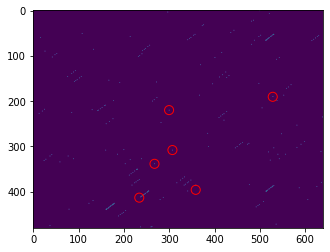

In [65]:
# Possibly learn a psf

Imaxima = morphology.h_maxima(Ires, 0.15)

plt.imshow(Imaxima)
for x, y in targets[:, frameid]:
    draw_target(plt.gcf().gca(), y, x)
plt.show()